# Isolated Functions

### Importing audio WAVs

Needed libraries:

In [559]:
import sys
import os
import numpy as np
import scipy as sp
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.signal import find_peaks

Static attributes and utility functions. These will need to be adapted in the project.

In [560]:
TEST_AUDIO_LOCATION = 'test_audio'
AUDIO_0 = '0_ThreeSeparateSounds.wav'
AUDIO_1 = '1_WellDistinctBeat.wav'
AUDIO_2 = '2_WellDistinctBeat.wav'
AUDIO_3 = '3_WellDistinctBeat.wav'
AUDIO_4 = '4_WellDistinctBeat.wav'
AUDIO_5 = '5_WellDistinctBeat.wav'
AUDIO_6 = '6_WellDistinctBeat.wav'
AUDIO_7 = '7_WellDistinctBeat.wav'
AUDIO_8 = '8_WellDistinctBeat.wav'
AUDIO_9 = '9_WellDistinctBeat.wav'
AUDIO_10 = '10_WellDistinctBeat.wav'

# Returns full path for the audio.
def full_path(audio_name):
    return os.path.join(TEST_AUDIO_LOCATION, audio_name)

# Display the audio so that it can be played inside jupyter.
def display_audio(audio_name):
    ipd.display(ipd.Audio(full_path(audio_name)))
    return

# [x, Fs] =  load(audio_name)
# Loads audio from file
def load(audio_name, newSr=None):
    return librosa.load(full_path(audio_name), sr=newSr)

# Draws the samples, just for jupyter.
def plot_samples(x, Fs, width=12, height=4):
    plt.figure(figsize=(width, height))
    time_axis = np.arange(x.shape[0]) / Fs
    plt.plot(time_axis, x)
    plt.xlim((time_axis[0], time_axis[-1]))
    plt.xlabel('Time (s)')
    plt.ylabel('Waveform')
    return

def plot_spectrogram(Y_dB, time_axis, frequency_axis, width, height):
    x_ext = (time_axis[1] - time_axis[0]) / 2
    y_ext = (frequency_axis[1] - frequency_axis[0]) / 2
    
    image_extent = [time_axis[0] - x_ext, time_axis[-1] + x_ext, 
                   frequency_axis[0]-y_ext, frequency_axis[-1]+y_ext]
    
    plt.figure(figsize=(width, height))
    plt.imshow(Y_dB, aspect='auto', origin='lower', extent = image_extent)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    return


Functions definitions:

In [599]:
# This calculates the abs() of the spectrogram of the audio in dB. Uses hanning window.
def spectrogram(x, Fs, N=2048, H=1024):
    
    # Simple stft
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hanning')
    
    # stft to spectrum in dB
    Y = np.abs(X) ** 2
    eps = np.finfo(float).eps
    Y_dB = 10*np.log10(Y+eps)
    
    time_axis = np.arange(X.shape[1]) * H / Fs
    frequency_axis = np.arange(X.shape[0]) * Fs / N
    
    return Y_dB, time_axis, frequency_axis


def warp(x, low, interval):
    return np.remainder(x - low, interval) + low


def princarg(x):
    return warp(x, -np.pi, 2*np.pi)


def compute_novelty(x, Fs=1, N=512, H=256):
   
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hanning')
    Fs_feature = Fs/H
    mag = np.abs(X)
    
    phase = np.angle(X)/(2*np.pi)
    
    unwr_phase = np.zeros_like(X, dtype=float);
    for i in np.arange(X.shape[1]):
        unwr_phase[:,i] = np.unwrap( np.angle(X[:,i]) )
    
    phase_shift = unwr_phase[:,2:] - 2*unwr_phase[:,1:-1] + unwr_phase[:,0:-2]
    phase_shift = princarg(phase_shift)    
    
    
    amp_pred = mag[:,1:-1]
    amp_true = mag[:,2:]
    
    novelty_complex = (amp_pred**2 + amp_true**2 - 2 * amp_pred * amp_true * np.cos(phase_shift))
    
    novelty_complex[novelty_complex<0]=0
    
    novelty_complex = np.sqrt(novelty_complex)
    
    novelty_complex = np.sum(novelty_complex, axis=0)
    novelty_complex = np.concatenate((novelty_complex, np.array([0, 0])))
    
    return novelty_complex, Fs_feature


def compute_APM(x, lags):
    N = len(x)
    n_lags = len(lags)
    max_lag = lags[-1]                   
    P = np.zeros((n_lags, max_lag))
    C = np.zeros((n_lags, max_lag))
    # for all the lags k
    for lag_index in np.arange(n_lags):
        k = lags[lag_index]                   
        for phi in np.arange(k):
            n = np.ceil(( N-phi)/k)                       
            i = np.array(phi + k*np.arange(n), dtype=int) 
            P[lag_index,phi] = np.sum(x[i[0:-1]] * x[i[1:]])    
            C[lag_index,phi] = n-1                               
    C[C==0]=1 

    return P, C


def smooth(x, win_length=11, win_type='boxcar'):
    if x.ndim != 1:
        raise ValueError('smooth only accepts 1 dimension arrays.')

    if x.size < win_length:
        raise ValueError('Input vector needs to be bigger than window size.')

    if win_length<3:
        return x
    # mirror pad
    s = np.pad(x, int(win_length/2), mode='reflect')   
    
    # create window
    w = sp.signal.windows.get_window(win_type, win_length)
    
    # convolve with normalized window
    y=np.convolve(w/w.sum(), s, mode='valid')
    
    #normalize
    y=y/(np.max(y))
    
    #padding for garantee the same len of x and y
    pad_width = len(y) - len(x)
    y = np.pad(y, pad_width)
    
    # return the useful part of y
    return y

def global_BPM_estimation(APM, Fs, lags):
    n_k = APM.shape[0]
    kmin = lags[0]
    
    #hihgest peak value of APM
    max_APM = 0;
    #k value associated to the APM's peak
    max_k = 0;
    
    #Look at which K is associated the higher peak of APM
    for k in np.arange(n_k):
        for phi in np.arange(k):
            if(APM[k,phi] > max_APM):
                max_APM = APM[k,phi];
                max_k = k + kmin
    
    #Compute the BPM given the max k
    BPM = np.around(60/(1/Fs*max_k))
    
#     print(Fs)
#     print(max_k)
#     print(BPM)
    
    return BPM


def k_phi_extract(APM, lags):
    
    max_val = []
    phi = []
    kmin = lags[0]
    
    # Get the max of each row
    for k in np.arange(APM.shape[0]):
        max = np.max(APM[k,:])
        max_val.append(max)
        
    max_val = max_val / np.max(max_val) * 1.25 
    # Get the peaks on the row
    k = np.argmax(max_val)
    max_k_value = np.max(max_val)
    
    second_max_val = np.delete(max_val, np.where(max_val==np.max(max_val)))
    second_k = np.argmax(second_max_val)
    second_max_k_value = np.max(max_val)
    
    only_one=False
    n_erased=1
    
    while(np.absolute(k-second_k) < 10):
        second_max_val = np.delete(second_max_val, np.where(second_max_val==np.max(second_max_val)))
        n_erased += 1
        second_k = np.argmax(second_max_val)
        second_max_k_value = np.max(second_max_val)
        if(len(second_max_val)==0 or second_max_k_value <0.8):
            only_one=True
            break
            
    print(n_erased)
    
    if(not only_one):
        second_k = np.argmax(second_max_val) + n_erased
        second_max_k_value = np.max(second_max_val) 
        k = [k, second_k]
        # Extract the phi position of the peaks
        for i in range(len(k)):
            phi.append(np.argmax(APM[k[i],:]))
    else:
        k = [k]
        phi = np.argmax((APM[k,:]))
        
    k += kmin
    print('k:', k)
    
    return k, phi, only_one 


def peaks_to_divisions(P_x, Fs_nov, x, Fs, lags):
    ks, phis, only_one = k_phi_extract(P_x, lags)
    
    bpm = [0, 0]
    samples_each_beat = [0, 0]
    how_many_beats_in_recording = [0, 0]
    
    bpm[0] = np.around(60/(1/Fs_nov*ks[0]))
    samples_each_beat[0] = 60*Fs/bpm[0]
    how_many_beats_in_recording[0] = np.rint(len(x)/samples_each_beat[0])
    
#     print(Fs_nov)
#    print(np.around(60/(1/Fs_nov*ks[1])))
#     print(bpm[0])
#     print(samples_each_beat[0])
    
    if(not only_one):
        bpm[1] = np.around(60/(1/Fs_nov*ks[1]))
        samples_each_beat[1] = 60*Fs/bpm[1]
        how_many_beats_in_recording[1] = np.rint(len(x)/samples_each_beat[1])
        dividend = np.max([how_many_beats_in_recording[0]/how_many_beats_in_recording[1], how_many_beats_in_recording[1]/how_many_beats_in_recording[0]])
        print(bpm)
        print(len(x)/samples_each_beat[1])
        if dividend%1==0:
            divisions = np.max(how_many_beats_in_recording)
        else:
            divisions = how_many_beats_in_recording[0]*how_many_beats_in_recording[1]
    else:
        divisions = how_many_beats_in_recording[0]
    
    return divisions, bpm
    
    
    

Usage:

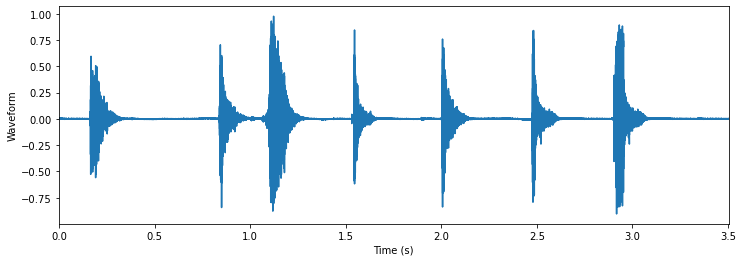

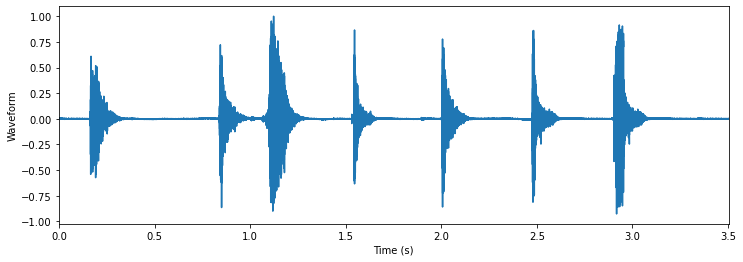

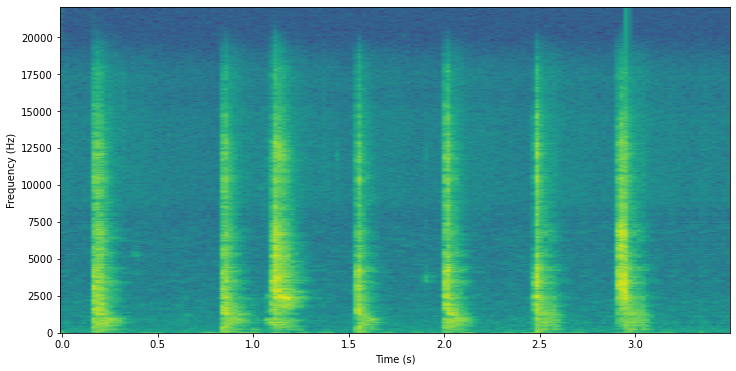

In [562]:
display_audio(AUDIO_4)

# Load audio
[x, Fs] = load(AUDIO_4)
#print(Fs)
plot_samples(x, Fs)

# Normalization of samples
maxX = np.max(x)
x = x/maxX
plot_samples(x, Fs)

# FFT
[Y_dB, t_axis, f_axis] = spectrogram(x, Fs)
plot_spectrogram(Y_dB, t_axis, f_axis, 12, 6)


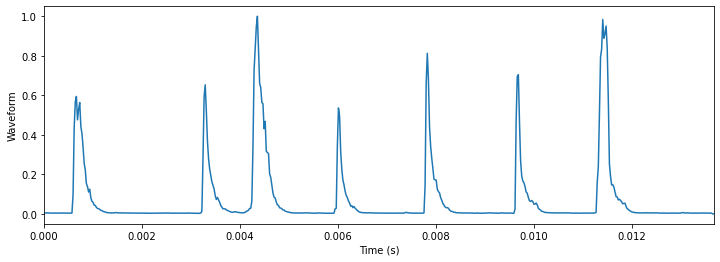

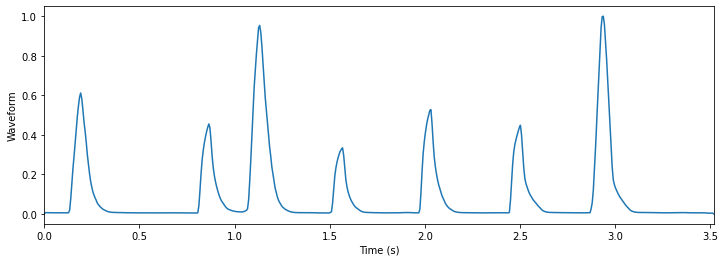

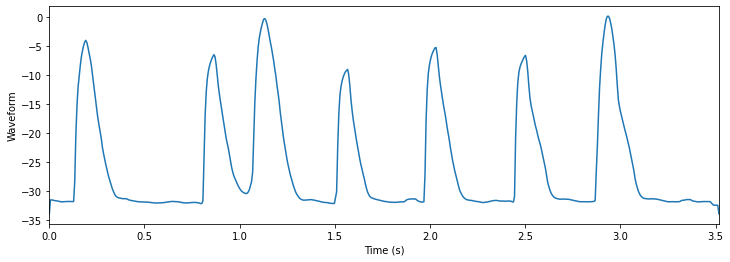

In [563]:
# Novelty Function
nov_x, Fs_nov = compute_novelty(x,Fs=Fs)
#print(Fs_nov)
nov_x = nov_x/(np.max(nov_x)) # normalize
plot_samples(nov_x, Fs)

# k
kmin = 19
kmax = 130
lags = np.arange(kmin,kmax)

# Smoothing
smooth_nov_x = smooth(nov_x,win_length=10)
plot_samples(smooth_nov_x, Fs_nov)

# Noise & dB
noise = 0.02 + 0*np.random.randn(len(smooth_nov_x))
noisy_smooth_nov_x = smooth_nov_x + noise
noisy_smooth_nov_x = 20*np.log10(noisy_smooth_nov_x) # to dB to isolate and level better the peaks
plot_samples(noisy_smooth_nov_x, Fs_nov)


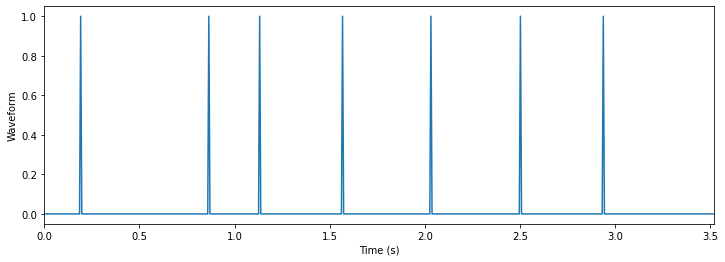

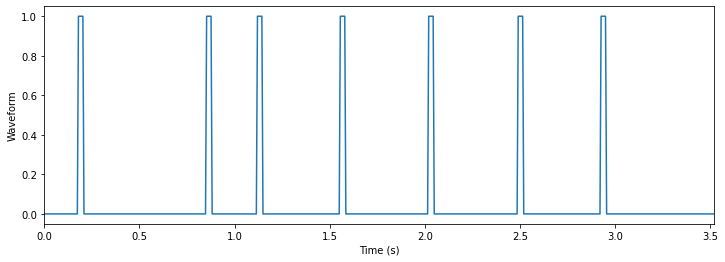

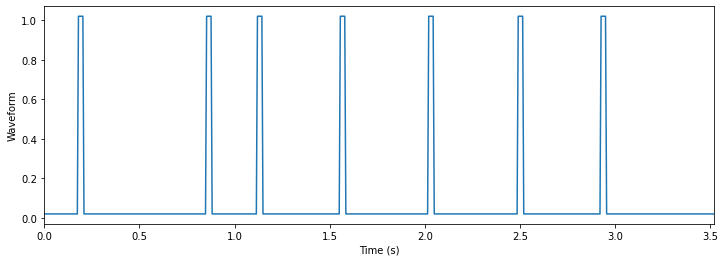

In [564]:
# Peaks
peaks = find_peaks(noisy_smooth_nov_x, height=-20)[0]
clicks = np.zeros(len(noisy_smooth_nov_x))
for i in np.arange(len(noisy_smooth_nov_x)):
    if i in peaks:
        clicks[i] = 1
    else:
        clicks[i] = 0

plot_samples(clicks, Fs_nov)

# Smoothing
smooth_clicks = smooth(clicks,win_length=5)
smooth_clicks[0] = 0
plot_samples(smooth_clicks, Fs_nov)

# Noise
noise = 0.02 + 0*np.random.randn(len(clicks))
noisy_clicks = smooth_clicks + noise
plot_samples(noisy_clicks, Fs_nov)
        


Text(0.5, 1.0, '$P(\\phi, k)$ of x')

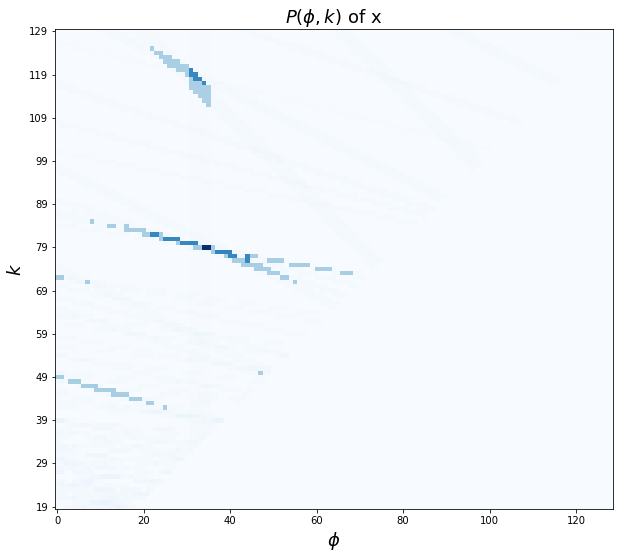

In [565]:
# APM
P_x = compute_APM(noisy_clicks, lags)[0]
#print("Shape of x:",P_x.shape)
plt.figure(figsize=(20,30))
plt.subplot(3,1,1)
plt.imshow(P_x, cmap=plt.get_cmap('Blues'), origin='lower')
plt.xlabel(r'$\phi$', fontsize=18)
plt.ylabel(r'$k$', fontsize=18)
plt.yticks(np.arange(0, kmax - kmin, 10), lags[::10])
plt.title(r'$P(\phi, k)$ of x', fontsize=18)

In [600]:
# BPM
global_BPM = global_BPM_estimation(P_x,Fs_nov,lags)
print("Estimated BPM of X:", global_BPM,"BPM")

# Apm peaks to divisions
divisions, bpm = peaks_to_divisions(P_x, Fs_nov, x, Fs, lags) 
print('Divisions: ', divisions)

Estimated BPM of X: 131.0 BPM
5
k: [ 79 116]
[131.0, 89.0]
5.196543839758125
Divisions:  40.0
